# Single-Cell Filtering and Processing

## Packages

In [1]:
import re
import os
import sys
import glob
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
print(sc.__version__)

1.9.1


In [2]:
# Install pybiomart: needed for sc.queries.mitochondrial_genes
#! pip install pybiomart
# Install louvain: needed for sc.tl.louvain
#! pip install louvain
# Install adjustText: needed for formatting for scatterplots
#! pip install adjustText

In [3]:
# Versions
sc.settings.verbosity = 3
sc.logging.print_header()

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.21.2 scipy==1.7.1 pandas==1.3.2 scikit-learn==0.24.2 statsmodels==0.13.5 python-igraph==0.10.2 louvain==0.8.0 pynndescent==0.5.8


## Reading in Data

In [4]:
# Data Directory
os.chdir('../01.CellRanger')

# Get Data Paths
files = glob.glob('**/outs/filtered_feature_bc_matrix.h5', recursive=True)
print(files)

# Reading in CellRanger Data
dataList = []
for fn in files:
    adata = sc.read_10x_h5(fn)
    adata.var_names_make_unique()
    adata.obs['sample'] = [fn.split('/')[0]] * adata.obs.shape[0]
    # Filtering out cells with fewer than 1100 UMI
    sc.pp.filter_cells(adata, min_counts=1100)
    dataList.append(adata)

# Back to Filtering Directory
os.chdir('../03.CellFiltering')

['G1_1/outs/filtered_feature_bc_matrix.h5', 'G4_2/outs/filtered_feature_bc_matrix.h5', 'G5_1/outs/filtered_feature_bc_matrix.h5', 'G2_2/outs/filtered_feature_bc_matrix.h5', 'G3_1/outs/filtered_feature_bc_matrix.h5', 'G1_3/outs/filtered_feature_bc_matrix.h5', 'G7_1/outs/filtered_feature_bc_matrix.h5', 'G2_1/outs/filtered_feature_bc_matrix.h5', 'G5_2/outs/filtered_feature_bc_matrix.h5', 'G4_1/outs/filtered_feature_bc_matrix.h5', 'G3_2/outs/filtered_feature_bc_matrix.h5', 'G7_2/outs/filtered_feature_bc_matrix.h5']
reading G1_1/outs/filtered_feature_bc_matrix.h5
 (0:00:03)


/home/cbadger/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


filtered out 58995 cells that have less than 1100 counts
reading G4_2/outs/filtered_feature_bc_matrix.h5
 (0:00:04)
filtered out 50631 cells that have less than 1100 counts
reading G5_1/outs/filtered_feature_bc_matrix.h5
 (0:00:03)
filtered out 63488 cells that have less than 1100 counts
reading G2_2/outs/filtered_feature_bc_matrix.h5
 (0:00:02)
filtered out 69762 cells that have less than 1100 counts
reading G3_1/outs/filtered_feature_bc_matrix.h5
 (0:00:02)
filtered out 68032 cells that have less than 1100 counts
reading G1_3/outs/filtered_feature_bc_matrix.h5
 (0:00:03)
filtered out 59028 cells that have less than 1100 counts
reading G7_1/outs/filtered_feature_bc_matrix.h5
 (0:00:03)
filtered out 54111 cells that have less than 1100 counts
reading G2_1/outs/filtered_feature_bc_matrix.h5
 (0:00:02)
filtered out 57717 cells that have less than 1100 counts
reading G5_2/outs/filtered_feature_bc_matrix.h5
 (0:00:03)
filtered out 55820 cells that have less than 1100 counts
reading G4_1/ou

In [5]:
adata = dataList[0].concatenate(dataList[1:])

/home/cbadger/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


In [6]:
adata.obs = adata.obs.drop(['n_counts'],axis=1)
adata.obs

,sample,batch
AAACCCAAGCACCGAA-1-0,G1_1,0
AAACCCAAGGTGATCG-1-0,G1_1,0
AAACCCAAGTCCTACA-1-0,G1_1,0
AAACCCACAAGCCCAC-1-0,G1_1,0
AAACCCACAGACCAGA-1-0,G1_1,0
...,...,...
TTTGTTGAGGCGACAT-1-11,G7_2,11
TTTGTTGCAGCAGTGA-1-11,G7_2,11
TTTGTTGGTGGATCAG-1-11,G7_2,11
TTTGTTGGTGGCCCAT-1-11,G7_2,11


## Cell and Gene Filtering

In [7]:
# Keep cells with 200+ genes
sc.pp.filter_cells(adata, min_genes=200)

# Keep genes expressed in 10+ cells
sc.pp.filter_genes(adata, min_cells=10)

filtered out 18679 genes that are detected in less than 10 cells


In [8]:
adata

AnnData object with n_obs × n_vars = 180740 × 31921
    obs: 'sample', 'batch', 'n_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'

normalizing counts per cell
    finished (0:00:01)


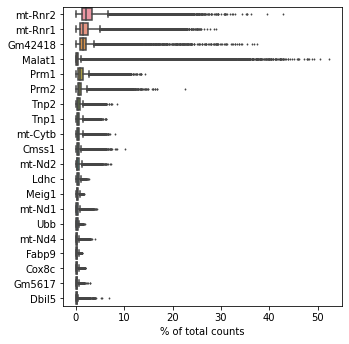

In [9]:
sc.pl.highest_expr_genes(adata, n_top=20, )

In [10]:
# Calculating Mitochondrial Count Percentage
mito_gene_list = list(sc.queries.mitochondrial_genes('mmusculus')['external_gene_name'])
adata.var['mt'] = np.in1d(adata.var_names, mito_gene_list)
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

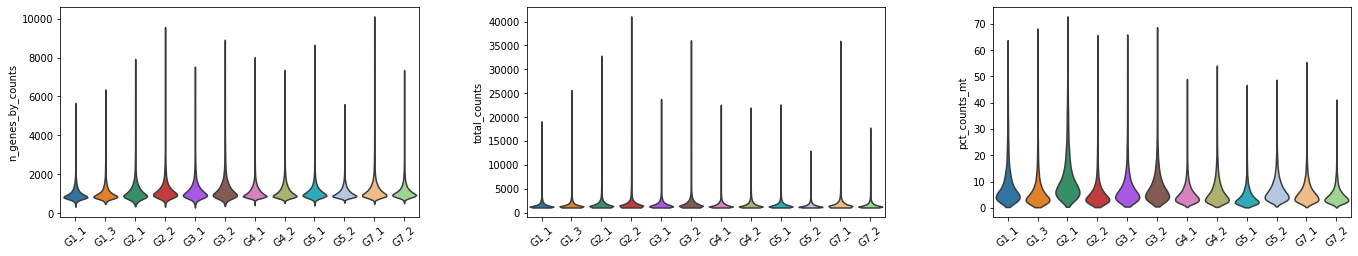

In [11]:
# Visualizing QC Metrics
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], groupby='sample',
             stripplot=False, multi_panel=True, rotation=40)

In [12]:
adata.obs

,sample,batch,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt
AAACCCAAGCACCGAA-1-0,G1_1,0,1080,1080,3329.0,573.0,17.212376
AAACCCAAGGTGATCG-1-0,G1_1,0,1129,1129,1820.0,78.0,4.285715
AAACCCAAGTCCTACA-1-0,G1_1,0,1238,1238,2254.0,364.0,16.149067
AAACCCACAAGCCCAC-1-0,G1_1,0,734,734,1182.0,270.0,22.842640
AAACCCACAGACCAGA-1-0,G1_1,0,2627,2627,5715.0,801.0,14.015748
...,...,...,...,...,...,...,...
TTTGTTGAGGCGACAT-1-11,G7_2,11,1079,1078,1528.0,46.0,3.010471
TTTGTTGCAGCAGTGA-1-11,G7_2,11,878,878,1381.0,233.0,16.871832
TTTGTTGGTGGATCAG-1-11,G7_2,11,2320,2320,3415.0,83.0,2.430454
TTTGTTGGTGGCCCAT-1-11,G7_2,11,929,929,1292.0,42.0,3.250774


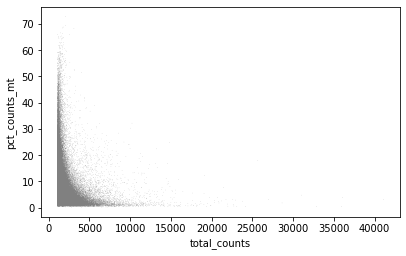

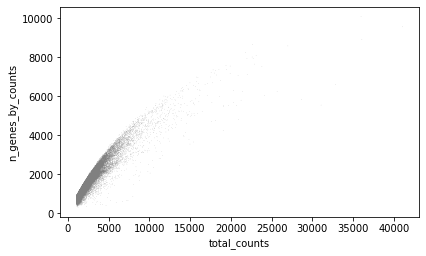

In [13]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [14]:
# n_genes_by_counts: The number of genes with at least 1 count in a cell
# pct_counts_mt: Proportion of total counts for a cell which are mitochondrial

# Keeping cells with fewer than 6000 unique genes found
adata = adata[adata.obs.n_genes_by_counts < 6000, :]

# Keeping cells with less than 15% mitochondrial reads
adata = adata[adata.obs.pct_counts_mt < 15, :]

## Normalization and Transformation

In [15]:
# Counts per 10,000
sc.pp.normalize_total(adata, target_sum=1e4)

/home/cbadger/.local/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)


In [16]:
sc.pp.log1p(adata)

In [17]:
adata

AnnData object with n_obs × n_vars = 165585 × 31921
    obs: 'sample', 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'sample_colors', 'log1p'

## Variable Gene Selection

In [18]:
sc.pp.highly_variable_genes(adata, min_mean=0.025, max_mean=3, min_disp=0.5)
print(len(adata.var.highly_variable[adata.var.highly_variable==True]))

extracting highly variable genes
    finished (0:00:07)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
4095


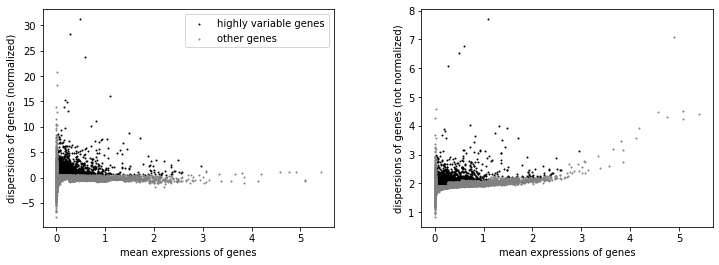

In [19]:
sc.pl.highly_variable_genes(adata)

In [20]:
adata.raw = adata

In [21]:
adata = adata[:, adata.var.highly_variable]

In [22]:
sc.pp.regress_out(adata, ['total_counts','pct_counts_mt'])

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:10:10)


## Scaling Data

In [23]:
sc.pp.scale(adata, max_value=8)

In [24]:
adata

AnnData object with n_obs × n_vars = 165585 × 4095
    obs: 'sample', 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'sample_colors', 'log1p', 'hvg'

## Dimension Reduction

In [25]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:53)


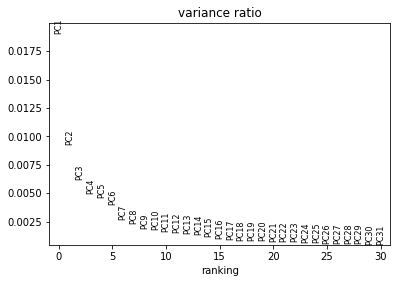

In [26]:
sc.pl.pca_variance_ratio(adata, log=False)

In [27]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=20)

computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:39)


## Cell Clustering

In [28]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:01:46)


In [29]:
#sc.tl.leiden(adata,resolution=.4)
sc.tl.leiden(adata,resolution=.6)
    # Resolution: Higher values lead to more clusters

running Leiden clustering
    finished: found 20 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:02:15)


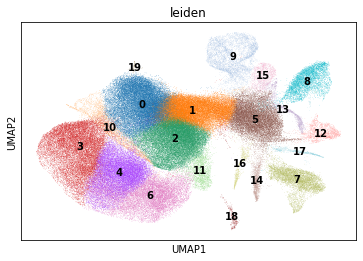

In [30]:
sc.pl.umap(adata,color=['leiden'],legend_loc='on data',ncols=2)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 17 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:41)


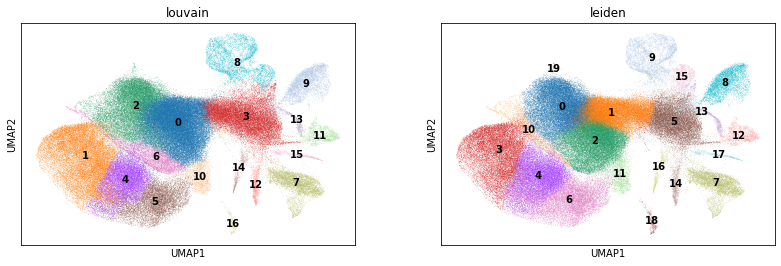

In [31]:
sc.tl.louvain(adata,resolution=.45)
sc.pl.umap(adata,color=['louvain','leiden'], legend_loc='on data')

## Cluster Ranked Genes

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:10:47)


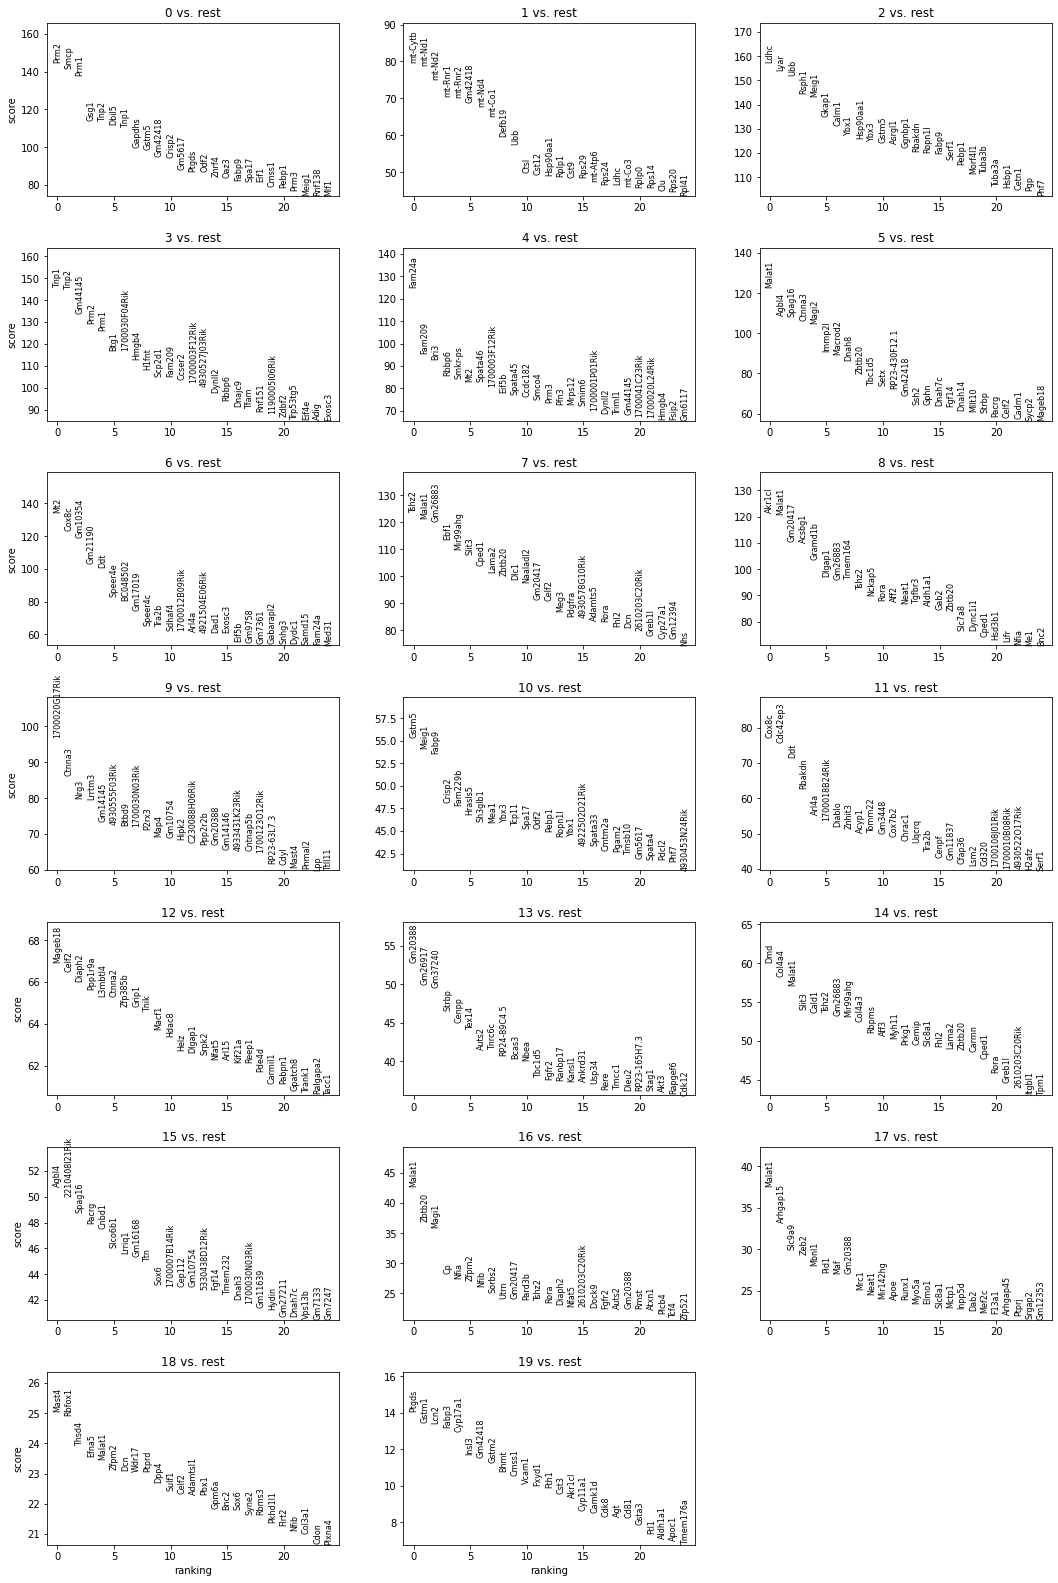

In [32]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon', pts=True)
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, ncols=3)

In [33]:
array = []
#for i in range(14):
for i in range(20):
    index = list(map(lambda x: x[i],adata.uns['rank_genes_groups']['names']))
    score = pd.Series(map(lambda x: x[i],adata.uns['rank_genes_groups']['scores']),index=index,name='scores')
    logfc = pd.Series(map(lambda x: x[i],adata.uns['rank_genes_groups']['logfoldchanges']),index=index,name='logFC')
    pv = pd.Series(map(lambda x: x[i],adata.uns['rank_genes_groups']['pvals_adj']),index=index,name='pvals_adj')
    markers1 = pd.concat([score,logfc,pv],join='inner',axis=1)
    markers1 = markers1[markers1['logFC']>0.8].head(n=200)
    markers1['cluster'] = [i] * markers1.shape[0]
    array.append(markers1)
markers = pd.concat(array,join='inner',axis=0)
markers.to_csv('scanpy_marker_genes.csv')

In [34]:
# Adding Sample Metadata
meta = pd.read_csv('sample_anno.csv',index_col=0)
new_obs = adata.obs.merge(meta[['Group','Drug','Dose','Description']], left_on='sample', right_index=True, how='inner')

In [35]:
adata.obs = new_obs

## Saving Filtered and Processed Object

In [36]:
# Saving Filtered and Transformed Object
adata.write('study1_filt_clust.h5ad')

## Extra

In [ ]:
sc.pl.umap(adata,color=['total_counts'])

In [ ]:
from matplotlib.pyplot import rc_context
with rc_context({'figure.figsize': (7, 3)}):
    sc.pl.violin(adata, keys='total_counts', groupby='leiden', rotation=0, jitter=False, log=True)
    sc.pl.violin(adata, keys='n_genes', groupby='leiden', rotation=0, jitter=False)
    sc.pl.violin(adata, keys='pct_counts_mt', groupby='leiden', rotation=0, jitter=False)

In [ ]:
sc.pl.umap(adata,color=['total_counts','n_genes_by_counts'],vmax=[5000,3000],ncols=2)

In [ ]:
sc.pl.umap(adata,color='sample',frameon=False)